In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import random

# for easier reading np
np.set_printoptions(precision=3,suppress=True)

# Data

100%|██████████| 9912422/9912422 [00:00<00:00, 32227809.50it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 80595937.34it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 39007379.69it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 10203818.30it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



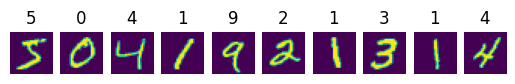

In [2]:
# Prepare the data
from torchvision.datasets import MNIST

db_train = MNIST(root="./", train=True, transform=None, target_transform=None, download=True)
db_test = MNIST(root="./", train=False, transform=None, target_transform=None, download=True)
def to1hot(labels):
    """Converts an array of class labels into their 1hot encodings.
    Assumes that there are at most three classes."""
    return torch.eye(10)[labels]

for i in range(10):
    img, lbl = db_train[i]
    plt.subplot(1, 10, i+1)
    plt.imshow(img)
    plt.title(lbl)
    plt.axis(False)

In [3]:
# Reading the dataset
def data_iter(batch_size, db):
    num_examples = len(db)

    # The examples are read at random, in no particular order
    indices = list(range(num_examples))
    random.shuffle(indices)
    indices = indices[:10000]
    for i in range(0, 10000, batch_size):
        X, Y = [], []
        for j in indices[i:i + batch_size]:
            img, lbl = db[j]

            # Process image
            img = torch.from_numpy(np.array(img))   # Convert PIL to numpy and then PyTorch
            img = img.view(28*28)                   # Image is 28x28. For our MLP we want to reshape this into a large 768 array
            img = img.float() / 255.                # Make the pixel values between 0 and 1 (instead of between 0 and 255).

            lbl = torch.tensor(lbl)

            X.append(img), Y.append(lbl)
        yield torch.stack(X), torch.stack(Y)

# Check data reader
for X_batch, y_batch in data_iter(batch_size=10, db=db_train):
    print('X_batch', X_batch.shape, X_batch.dtype)
    print('y_batch', y_batch.shape, y_batch.dtype)
    break

X_batch torch.Size([10, 784]) torch.float32
y_batch torch.Size([10]) torch.int64


# Model

In [16]:
# Define Model
from torch import nn
class Linear(nn.Module):
    def __init__(self, input_dim):
        super(Linear, self).__init__()
        self.layer1 = nn.Linear(input_dim, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.softmax(self.layer1(x))
        return x

class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dim, 350)
        self.layer2 = nn.Linear(350, 50)
        self.layer3 = nn.Linear(50, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

# Check model
model = MLP(28*28)
for X_batch, y_batch in data_iter(batch_size=16, db=db_train):
    out_batch = model(X_batch)
    print('X_batch', X_batch.shape)
    print('out_batch', out_batch.shape)
    break

X_batch torch.Size([16, 784])
out_batch torch.Size([16, 10])


# Training

In [21]:
# Optimization algorithms
def sgd(model, lr):
    """Minibatch stochastic gradient descent."""
    for p in model.parameters():
        p.data -= lr * p.grad
        p.grad = None

def sgd_with_momentum(model, lr, momentum=0.9):
    if not hasattr(model, 'velocities'):
        model.velocities = {}
        for p in model.parameters():
            model.velocities[p] = torch.zeros_like(p.data)

    for p in model.parameters():
        model.velocities[p] = momentum * model.velocities[p] + lr * p.grad
        p.data -= model.velocities[p]
        p.grad = None

# Loss Functions and Accuracy Metric
def mse(y_hat, y):
    """MSE Loss."""
    loss_per_sample = (to1hot(y) - yhat).pow(2).sum(1)
    return loss_per_sample.mean()

# Loss Functions and Accuracy Metric
loss_fn = nn.CrossEntropyLoss()

def cross_entropy(y_hat, y):
    """Cross entropy Loss."""
    return loss_fn(y_hat, y)

def accuracy(y_hat, y):
    return (y_hat.argmax(dim=1) == y).float().mean()

# Check functions
yhat = torch.tensor([[0.2, 0.8, 0.1, 0, 0, 0, 0, 0, 0, 0],[0.6, 0.3, 0.1, 0, 0, 0, 0, 0, 0, 0]])
y = torch.tensor([1, 1])
loss = mse(yhat, y)
acc = accuracy(yhat, y)
print(f'loss = {loss}    acc = {acc}')

loss = 0.4749999940395355    acc = 0.5


In [26]:
# Hyperparameters
lr = 0.01
batch_size = 16
num_epochs = 50
momentum = 0.9

In [27]:
# Training
# model = Linear(28*28)
model = MLP(28*28)
for epoch in range(num_epochs):
    losses = []
    for X_batch, y_batch in data_iter(batch_size=batch_size, db=db_train):
        yhat = model(X_batch)
        l = cross_entropy(yhat, y_batch)  # Use cross-entropy loss

        l.backward()

        sgd_with_momentum(model, lr, momentum)  # Use SGD with momentum

        losses.append(l.detach().item())

    acc = []
    for X_batch, y_batch in data_iter(batch_size=16, db=db_test):
        yhat = model(X_batch)
        acc.append(accuracy(yhat, y_batch))

    print(f"Epoch {epoch+1}: Train Loss {np.mean(losses):.3f} Test Accuracy {np.mean(acc):.3f}", flush=True)

Epoch 1: Train Loss 0.763 Test Accuracy 0.904
Epoch 2: Train Loss 0.281 Test Accuracy 0.931
Epoch 3: Train Loss 0.210 Test Accuracy 0.948
Epoch 4: Train Loss 0.166 Test Accuracy 0.951
Epoch 5: Train Loss 0.148 Test Accuracy 0.956
Epoch 6: Train Loss 0.123 Test Accuracy 0.961
Epoch 7: Train Loss 0.106 Test Accuracy 0.967
Epoch 8: Train Loss 0.100 Test Accuracy 0.969
Epoch 9: Train Loss 0.092 Test Accuracy 0.969
Epoch 10: Train Loss 0.092 Test Accuracy 0.967
Epoch 11: Train Loss 0.087 Test Accuracy 0.967
Epoch 12: Train Loss 0.072 Test Accuracy 0.972
Epoch 13: Train Loss 0.078 Test Accuracy 0.973
Epoch 14: Train Loss 0.067 Test Accuracy 0.972
Epoch 15: Train Loss 0.067 Test Accuracy 0.974
Epoch 16: Train Loss 0.058 Test Accuracy 0.973
Epoch 17: Train Loss 0.059 Test Accuracy 0.973
Epoch 18: Train Loss 0.054 Test Accuracy 0.973
Epoch 19: Train Loss 0.047 Test Accuracy 0.975
Epoch 20: Train Loss 0.053 Test Accuracy 0.977
Epoch 21: Train Loss 0.045 Test Accuracy 0.973
Epoch 22: Train Loss 0

In [20]:
# Evaluation
with torch.no_grad():
    yhat, y = [], []
    for X_batch, y_batch in data_iter(batch_size=16, db=db_test):
        yhat.append(model(X_batch))
        y.append(y_batch)

yhat = torch.cat(yhat, dim=0).argmax(dim=1)
y = torch.cat(y, dim=0)
cm = to1hot(y).T@to1hot(yhat)
print('CM = \n', cm.numpy())

CM = 
 [[ 953.    0.    2.    3.    0.    2.   12.    1.    7.    0.]
 [   0. 1100.    3.    5.    1.    3.    4.    0.   19.    0.]
 [  12.    3.  892.   18.   17.    1.   19.   19.   39.   12.]
 [   4.    0.   20.  894.    1.   36.    6.   14.   20.   15.]
 [   2.    6.    4.    0.  894.    1.   12.    2.    9.   52.]
 [  16.    8.    8.   42.   24.  714.   19.   12.   41.    8.]
 [  19.    3.    4.    2.    8.   16.  899.    0.    7.    0.]
 [   4.   24.   35.    2.   12.    0.    2.  906.    5.   38.]
 [  12.   10.   13.   32.   10.   29.   15.   14.  824.   15.]
 [  11.    8.    8.   11.   43.   22.    2.   20.    6.  878.]]


b. Our train loss and test accuracy are 1.728 and 0.814 respectively for cross-entropy loss, compared to 0.194 and 0.896 for MSE. It seems like MSE is yielding better test accuracies, although I'd expect cross-entropy to perform better for classification tasks.

c. We're seeing a train loss of 0.289 and test accuracy of 0.925. Clearly, the MLP model has a much higher test accuracy, though it suffers a greater train loss.

d. It's clear that the SGD with momentum effectively optimizes the model, peaking at a test accuracy of 0.967 with a great train loss of 0.097. I think it'll flatten out here and not improve further.

e. As predicted, we begin to see that the model stops improving even with more epochs at a test accuracy of ~0.98.